### Whole-brain model 

In [1]:
import sys

sys.path.insert(1, "/home/INT/lima.v/projects/phase_amplitude_encoding")

In [2]:
import os

import jax
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from fooof import FOOOF
from fooof.plts.spectra import plot_spectra
from fooof.sim.gen import gen_aperiodic
from frites.core import copnorm_nd
from hoi.core import get_mi
from mne.time_frequency import psd_array_multitaper
from mne.time_frequency.tfr import tfr_array_morlet
from sklearn.metrics import mean_squared_error
from tqdm import tqdm

from src.models import simulate, simulate_delayed

/tmp/ipykernel_39233/4157350124.py:7: DeprecationWarning: 
The `fooof` package is being deprecated and replaced by the `specparam` (spectral parameterization) package.
This version of `fooof` (1.1) is fully functional, but will not be further updated.
New projects are recommended to update to using `specparam` (see Changelog for details).
  from fooof import FOOOF
/home/INT/lima.v/anaconda3/envs/test_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
jax.config.update("jax_platform_name", "cpu")

######################################################################################
#### FUNCTIONS
######################################################################################

In [4]:
# Extract area names
def _extract_roi(roi, sep):
    # Code by Etiene
    x_s, x_t = [], []
    for r in roi:
        _x_s, _x_t = r.split(sep)
        x_s.append(_x_s), x_t.append(_x_t)
    roi_c = np.c_[x_s, x_t]
    idx = np.argsort(np.char.lower(roi_c.astype(str)), axis=1)
    roi_s, roi_t = np.c_[[r[i] for r, i in zip(roi_c, idx)]].T
    return roi_s, roi_t

In [5]:
def xr_psd_array_multitaper(data, bandwidth=1.0, n_jobs=1, fmin=0.1, fmax=80):
    _, roi, _ = data.trials.values, data.roi.values, data.time.values

    psds_c, freqs, _ = psd_array_multitaper(
        data,
        data.fsample,
        fmin=fmin,
        fmax=fmax,
        n_jobs=n_jobs,
        bandwidth=bandwidth,
        output="complex",
    )

    # Spectra
    sxx = (psds_c * np.conj(psds_c)).mean((0, 2)).real

    sxx = xr.DataArray(sxx, dims=("roi", "freqs"), coords=(roi, freqs))

    return sxx

######################################################################################
#### LOAD EMPIRICAL POWER SPECTRA
######################################################################################

In [6]:
areas_data = np.array(
    [
        "AIP",
        "Caudate",
        "Claustrum",
        "Core",
        "DP",
        "F1",
        "F2",
        "F6",
        "F7",
        "FST",
        "Ins",
        "LIP",
        "MB",
        "MIP",
        "MST",
        "MT",
        "OPRO",
        "PBr",
        "PIP",
        "Putamen",
        "SII",
        "STPc",
        "TPt",
        "Thal",
        "V1",
        "V2",
        "V3",
        "V3A",
        "V4",
        "V4t",
        "V6A",
        "VIP",
        "a1",
        "a11",
        "a12",
        "a13",
        "a14",
        "a2",
        "a23",
        "a24D",
        "a24c",
        "a3",
        "a32",
        "a44",
        "a45A",
        "a45B",
        "a46D",
        "a46V",
        "a5",
        "a7A",
        "a7B",
        "a7M",
        "a7op",
        "a8B",
        "a8L",
        "a8M",
        "a8r",
        "a9/46D",
        "a9/46V",
    ],
    dtype=object,
)


area_names = [
    "V1",
    "V2",
    "V4",
    "DP",
    "MT",
    "a8M",
    "a5",
    "a8L",
    "TEO",  ##
    "a2",
    "F1",
    "STPc",
    "a7A",
    "a46D",
    "10",  ##
    "a9/46V",
    "a9/46D",
    "F5",  ##
    "TEpd",  ##
    "PBr",
    "a7M",
    "a7B",
    "F2",
    "STPi",  ##
    "PROm",  ##
    "F7",
    "a8B",
    "STPr",  ##
    "a24c",
]

In [7]:
session_numbers = os.listdir("/home/INT/lima.v/Results/phase_encoding/psd/lucy")

In [8]:
sxx, peak_freqs, peak_power = [], [], []

for session in tqdm(session_numbers):

    sxx_ = xr.load_dataarray(
        f"/home/INT/lima.v/Results/phase_encoding/psd/lucy/{session}/sxx.nc"
    )
    peak_freqs_ = xr.load_dataarray(
        f"/home/INT/lima.v/Results/phase_encoding/psd/lucy/{session}/peak_freqs.nc"
    )
    peak_power_ = xr.load_dataarray(
        f"/home/INT/lima.v/Results/phase_encoding/psd/lucy/{session}/peak_power.nc"
    )

    _, roi_data = _extract_roi(peak_freqs_.roi.values, "_")
    sxx_ = sxx_.assign_coords({"roi": roi_data}).groupby("roi").mean("roi")
    peak_freqs_ = (
        peak_freqs_.assign_coords({"roi": roi_data}).groupby("roi").mean("roi")
    )
    peak_power_ = (
        peak_power_.assign_coords({"roi": roi_data}).groupby("roi").mean("roi")
    )

    sxx += [sxx_]
    peak_freqs += [peak_freqs_]
    peak_power += [peak_power_]

100%|███████████████████████████████████████████| 62/62 [00:00<00:00, 79.07it/s]


In [9]:
peak_freqs = xr.concat(peak_freqs, "sessions").mean("sessions")[0]
peak_power = xr.concat(peak_power, "sessions").mean("sessions")[0]

In [10]:
# Data power spectrum
sxx_data = xr.concat(sxx, "sessions").mean("sessions").groupby("roi").mean("roi")[0]
# sxx_data = sxx_data / sxx_data.max("freqs")

In [11]:
unique_rois = sxx_data.roi.values

sca = ["Caudate", "Claustrum", "Thal", "Putamen"]

idx = np.logical_not([s in sca for s in unique_rois])

unique_rois[idx]

array(['AIP', 'Core', 'DP', 'F1', 'F2', 'F6', 'F7', 'FST', 'Ins', 'LIP',
       'MB', 'MIP', 'MST', 'MT', 'OPRO', 'PBr', 'PIP', 'SII', 'STPc',
       'TPt', 'V1', 'V2', 'V3', 'V3A', 'V4', 'V4t', 'V6A', 'VIP', 'a1',
       'a11', 'a12', 'a13', 'a14', 'a2', 'a23', 'a24D', 'a24c', 'a3',
       'a32', 'a44', 'a45A', 'a45B', 'a46D', 'a46V', 'a5', 'a7A', 'a7B',
       'a7M', 'a7op', 'a8B', 'a8L', 'a8M', 'a8r', 'a9/46D', 'a9/46V'],
      dtype=object)

######################################################################################
#### FLATTEN DATA PSD
######################################################################################

In [12]:
freqs = sxx_data.freqs.data

sxx_data_flat = []

for roi in unique_rois:

    fm = FOOOF(verbose=False)

    spectrum = sxx_data.sel(roi=roi).values

    fm.add_data(freqs, spectrum, [1, 80])
    fm.fit(freqs, spectrum, [1, 80])

    init_ap_fit = gen_aperiodic(
        fm.freqs, fm._robust_ap_fit(fm.freqs, fm.power_spectrum)
    )

    sxx_data_flat += [fm.power_spectrum - init_ap_fit]

sxx_data.values = np.stack(sxx_data_flat)

######################################################################################
#### FIT MODEL TO DATA
######################################################################################

In [13]:
# Swap parameters


if not (
    os.path.isfile("data/f_model.nc")
    and os.path.isfile("data/a_model.nc")
    and os.path.isfile("data/beta_model.nc")
):

    simulate_vmap = jax.vmap(
        simulate,
        in_axes=(None, None, 0, 0, None, 0, None, None, None, None, None, None),
    )

    beta_vec = np.linspace(1e-5, 1e-2, 30)
    f_vec = np.linspace(0.1, 80, 30)
    a_vec = np.linspace(-15, -2, 30)

    params = np.array(np.meshgrid(a_vec, f_vec, beta_vec)).T.reshape(-1, 3)

    n_trials = 50
    dt = 1e-4
    fsamp = 1 / dt
    time = np.arange(0, 0.4, 1 / fsamp)
    beta = 1e-4
    Npoints = len(time)
    decim = 10

    out = []

    for i in tqdm(range(n_trials)):

        out += [
            simulate_vmap(
                np.zeros(1),
                0,
                params[:, 1],
                params[:, 0],
                fsamp,
                params[:, 2],
                Npoints,
                None,
                0,
                "cpu",
                decim,
                "both",
            )
        ]

    data = xr.DataArray(
        np.stack(out).real,
        dims=("trials", "roi", "time"),
        coords=(range(50), range(len(params)), time[::decim]),
        attrs={"fsample": 1000},
    )

    sxx_sim = xr_psd_array_multitaper(data, bandwidth=5, n_jobs=5)
    sxx_sim = sxx_sim / sxx_sim.max("freqs")

    optm = []

    for roi in tqdm(unique_rois):

        mse = [
            mean_squared_error(sxx_data.sel(roi=roi), sxx_sim_) for sxx_sim_ in sxx_sim
        ]
        optm += [params[np.argmin(mse), :]]

    a_values, peak_freqs, beta_values = np.stack(optm).T

    peak_freqs = xr.DataArray(peak_freqs, dims=("roi"), coords=(unique_rois,))
    a_values = xr.DataArray(a_values, dims=("roi"), coords=(unique_rois,))
    beta_values = xr.DataArray(beta_values, dims=("roi"), coords=(unique_rois,))

    f_model = []

    for area in area_names:
        if area in peak_freqs.roi.values:
            f_model += [peak_freqs.sel(roi=area)]
        else:
            f_model += [-1]

    f_model = xr.DataArray(f_model, dims=("roi"), coords=(area_names,))

    f_model.values[8] = f_model.values[7]
    f_model.values[14] = f_model.values[13]
    f_model.values[17] = f_model.values[16]
    f_model.values[18] = f_model.values[17]
    f_model.values[23] = f_model.values[22]
    f_model.values[24] = f_model.values[23]
    f_model.values[27] = f_model.values[26]
    f_model = f_model.fillna(f_model.min())

    a_model = []

    for area in area_names:
        if area in peak_freqs.roi.values:
            a_model += [a_values.sel(roi=area)]
        else:
            a_model += [-1]

    a_model = xr.DataArray(a_model, dims=("roi"), coords=(area_names,))

    a_model.values[8] = a_model.values[7]
    a_model.values[14] = a_model.values[13]
    a_model.values[17] = a_model.values[16]
    a_model.values[18] = a_model.values[17]
    a_model.values[23] = a_model.values[22]
    a_model.values[24] = a_model.values[23]
    a_model.values[27] = a_model.values[26]

    beta_model = []

    for area in area_names:
        if area in beta_values.roi.values:
            beta_model += [beta_values.sel(roi=area)]
        else:
            beta_model += [-1]

    beta_model = xr.DataArray(beta_model, dims=("roi"), coords=(area_names,))

    beta_model.values[8] = beta_model.values[7]
    beta_model.values[14] = beta_model.values[13]
    beta_model.values[17] = beta_model.values[16]
    beta_model.values[18] = beta_model.values[17]
    beta_model.values[23] = beta_model.values[22]
    beta_model.values[24] = beta_model.values[23]
    beta_model.values[27] = beta_model.values[26]

    f_model.to_netcdf("data/f_model.nc")
    a_model.to_netcdf("data/a_model.nc")
    beta_model.to_netcdf("data/beta_model.nc")

else:

    f_model = xr.load_dataarray("data/f_model.nc")
    a_model = xr.load_dataarray("data/a_model.nc")
    beta_model = xr.load_dataarray("data/beta_model.nc")

#### Load anatomical data

In [14]:
data = np.load("../interareal/markov2014.npy", allow_pickle=True).item()

# Graph parameters
Nareas = 29  # Number of areas
# FLN matrix
flnMat = data["FLN"]
# Distance matrix
D = data["Distances"] * 1e-3 / 3.5
# Hierarchy values
h = np.squeeze(data["Hierarchy"].T)

eta = 4.0

#### Simulation parameters

In [15]:
ntrials = 100
dt = 1e-4
fsamp = 1 / dt
time = np.arange(-5, 3, 1 / fsamp)
beta = 1e-4
Npoints = len(time)
decim = 10
f = 40  # np.linspace(20, 60, Nareas)[::-1]  # Node natural frequency in Hz

flnMat = (1 + eta * h)[:, np.newaxis] * flnMat

seeds = np.random.randint(0, 10000, ntrials)

In [16]:
import matplotlib.pyplot as plt
import numpy as np


def gaussian_firing_rate(t, mean=0.5, std_dev=0.3, peak_rate=50):
    """Gaussian-shaped firing rate (zero before t=0)."""
    rate = peak_rate * np.exp(-0.5 * ((t - mean) / std_dev) ** 2)
    rate[t < 0] = 0  # No firing before t=0
    return rate


def boxcar_firing_rate(t, onset=0.2, duration=0.1, rate=50):
    """Boxcar (rectangular) firing rate: constant firing within a time window."""
    firing_rate = np.zeros_like(t)
    firing_rate[(t >= onset) & (t < onset + duration)] = rate
    return firing_rate


def generate_poisson_spikes(time, rate, dt):
    """Generates a binary Poisson spike train."""
    return (np.random.rand(len(time)) < (rate * dt)).astype(int)


def convolve_spikes(spike_train, tau=0.1, dt=0.001):
    """Convolves spike train with an exponential decay filter (corrected length)."""
    kernel_length = int(5 * tau / dt)  # Ensure full decay
    t = np.arange(0, kernel_length * dt, dt)
    kernel = np.exp(-t / tau)  # Exponential decay kernel
    kernel /= np.sum(kernel)  # Normalize

    convolved = np.convolve(spike_train, kernel, mode="full")[
        : len(spike_train)
    ]  # Trim to match length
    return convolved


def simulate_spiking_input(
    time, mean=0.5, std_dev=0.3, tau=0.1, dt=0.001, peak_rate=50
):
    """Simulates a Poisson spike train with an exponentially decaying memory."""
    rate = gaussian_firing_rate(time, mean, std_dev, peak_rate)
    spike_train = generate_poisson_spikes(time, rate, dt)
    filtered_signal = convolve_spikes(spike_train, tau, dt)
    return spike_train, rate, filtered_signal


def plot_results(time, spike_train, rate, filtered_signal):
    """Plots the spike train, firing rate, and convolved signal."""
    plt.figure(figsize=(12, 8))

    plt.subplot(3, 1, 1)
    plt.plot(time, spike_train, "|", markersize=10, color="black")
    plt.title("Poisson Spike Train")
    plt.xlabel("Time (s)")
    plt.ylabel("Spikes")
    plt.ylim(-0.5, 1.5)
    plt.grid(True)

    plt.subplot(3, 1, 2)
    plt.plot(time, rate, color="red", linewidth=2)
    plt.title("Firing Rate (Gaussian)")
    plt.xlabel("Time (s)")
    plt.ylabel("Rate (Hz)")
    plt.grid(True)

    plt.subplot(3, 1, 3)
    plt.plot(time, filtered_signal, color="blue", linewidth=2)
    plt.title("Filtered Spike Train (Exponential Memory)")
    plt.xlabel("Time (s)")
    plt.ylabel("Filtered Signal")
    plt.grid(True)

    plt.tight_layout()
    plt.show()


# Add a loop over trials to simulate the input
# This makes the inputs all different across trials or neurons

input_ext_n1 = np.zeros((ntrials, Npoints))
input_ext_n2 = np.zeros((ntrials, Npoints))
input_ext_n3 = np.zeros((ntrials, Npoints))
input_ext_n4 = np.zeros((ntrials, Npoints))
for i in range(ntrials):
    spike_train, rate, input_ext_n1[i] = simulate_spiking_input(
        time, mean=0.5, std_dev=0.2, tau=0.005, dt=dt, peak_rate=25
    )
    spike_train, rate, input_ext_n2[i] = simulate_spiking_input(
        time, mean=0.55, std_dev=0.2, tau=0.005, dt=dt, peak_rate=25
    )
    spike_train, rate, input_ext_n3[i] = simulate_spiking_input(
        time, mean=0.6, std_dev=0.2, tau=0.005, dt=dt, peak_rate=25
    )
    spike_train, rate, input_ext_n4[i] = simulate_spiking_input(
        time, mean=0.65, std_dev=0.2, tau=0.005, dt=dt, peak_rate=25
    )

# Create External Input matrix for model to node 1
Iext = np.zeros((ntrials, Nareas, Npoints))
# Assign input to node 1
Iext[:, 0, :] = input_ext_n1
# Create CS matrix
CS = Iext
Amplitudes = np.linspace(0.1, 10, ntrials)
seeds = np.random.randint(0, 10000, ntrials)

In [17]:
CS.shape

(100, 29, 80000)

In [18]:
out = []
for trial in tqdm(range(ntrials)):

    out += [
        simulate_delayed(
            flnMat,
            D,
            30,
            f_model.values,
            a_model.values,
            fsamp,
            beta_model,
            Npoints,
            0,
            seeds[trial],
            decim=decim,
            stim_mode="both",
        )
    ]

100%|█████████████████████████████████████████| 100/100 [02:16<00:00,  1.36s/it]


#### Convert to xarray

In [19]:
data = xr.DataArray(
    np.stack(out),
    dims=("trials", "roi", "times"),
    coords=(range(ntrials), area_names, time[::decim]),
).sel(times=slice(-2, 2))

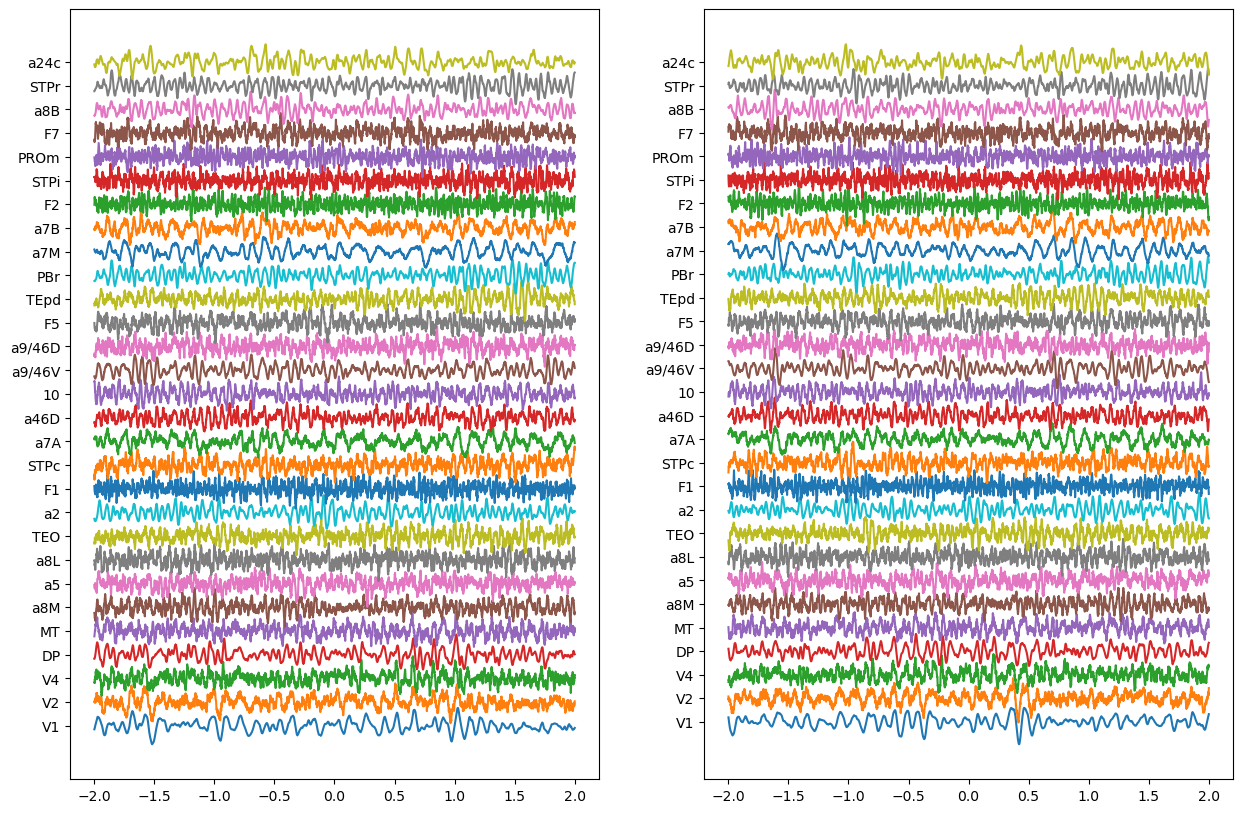

In [20]:
plt.figure(figsize=(15, 10))
z_data = (data - data.mean("times")) / data.std("times")
plt.subplot(1, 2, 1)
for i in range(Nareas):
    plt.plot(z_data[-1].times, z_data[0].values[i].real + (i * 3))
plt.yticks(np.arange(0, Nareas) * 3, area_names)
plt.subplot(1, 2, 2)
for i in range(Nareas):
    plt.plot(z_data[-1].times, z_data[-1].values[i].real + (i * 3))
plt.yticks(np.arange(0, Nareas) * 3, area_names);

In [21]:
Sxx, fc = psd_array_multitaper(data.real, fsamp // decim, 0, 80, bandwidth=1)

    Using multitaper spectrum estimation with 3 DPSS windows


In [22]:
Sxx = xr.DataArray(
    Sxx,
    dims=("trials", "roi", "freqs"),
    coords={"trials": data.trials.values, "roi": data.roi.values, "freqs": fc},
)

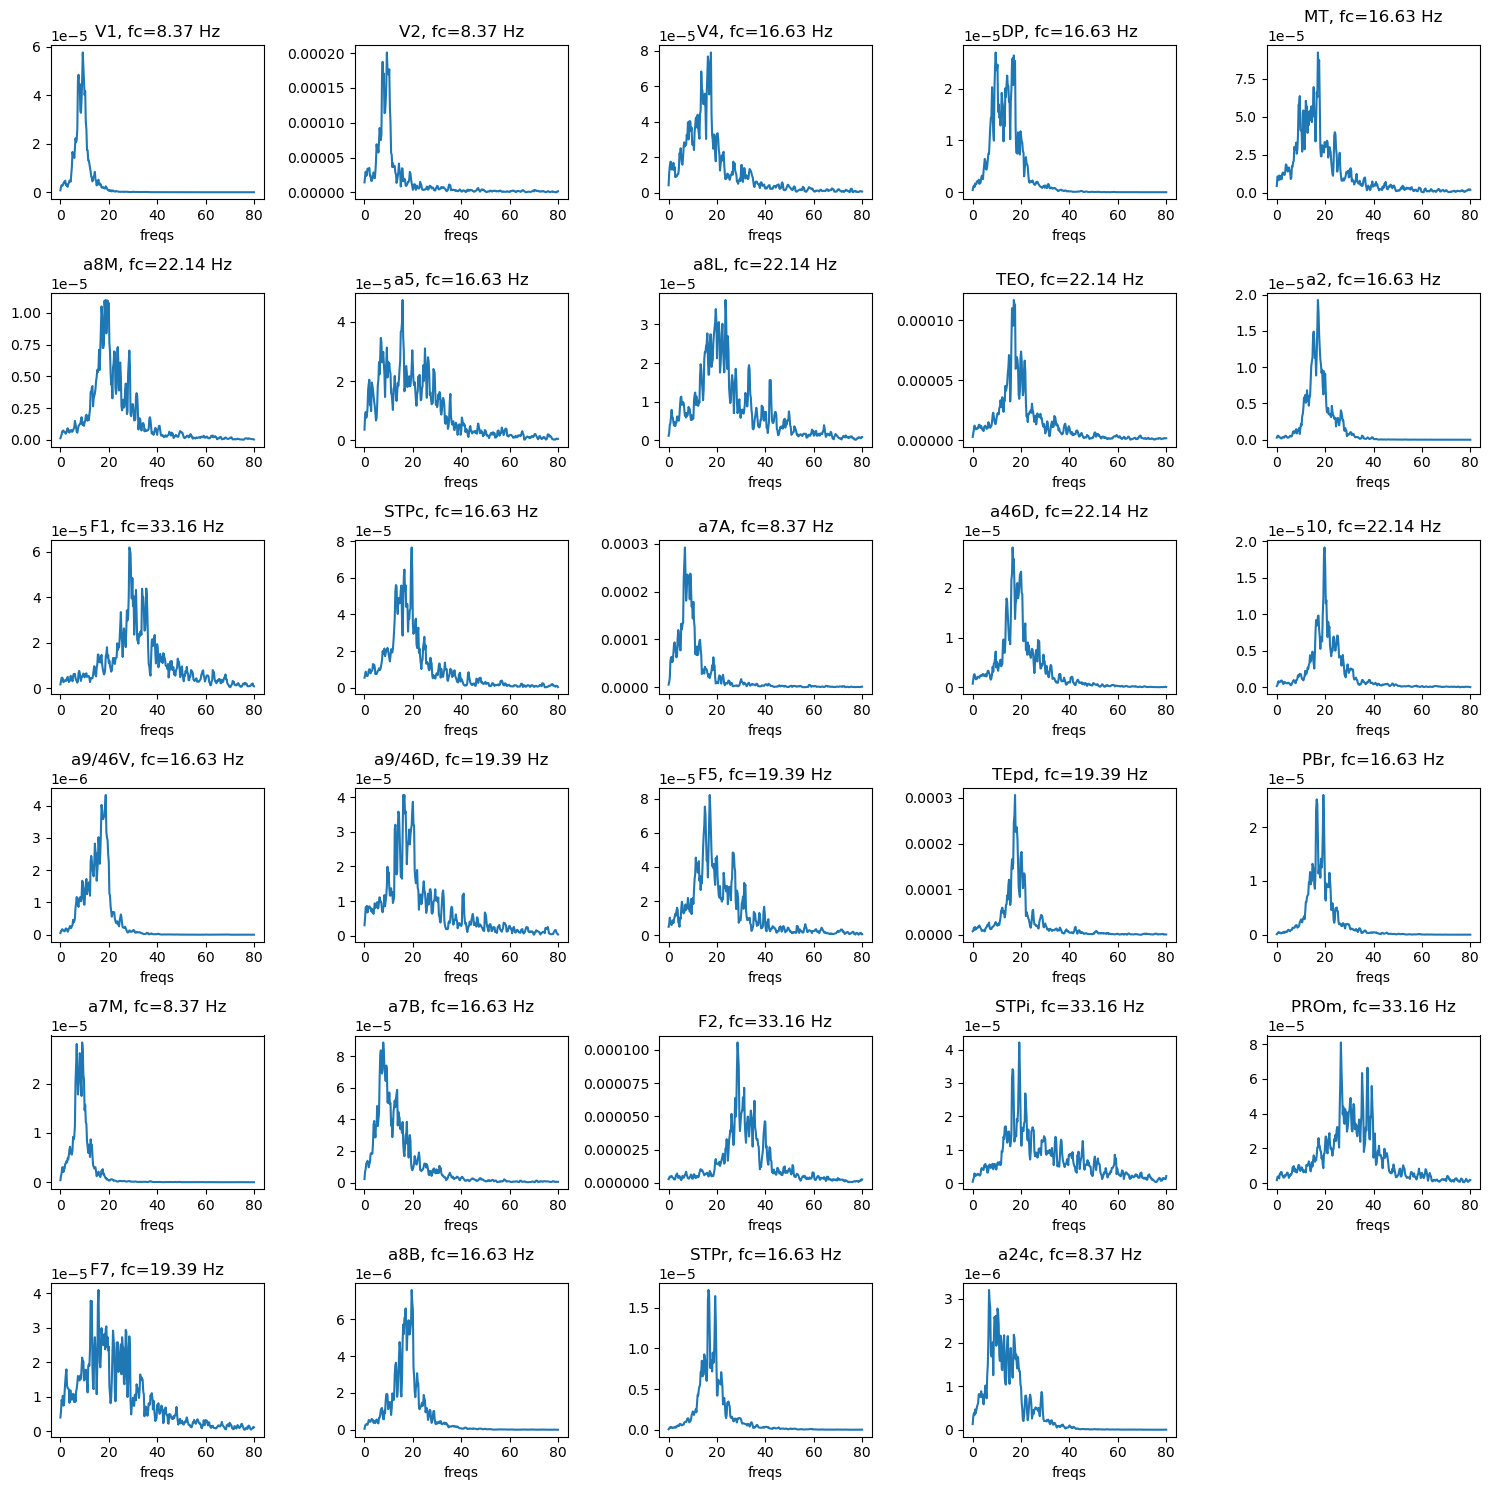

In [23]:
plt.figure(figsize=(15, 15))
for pos, i in enumerate(range(Nareas)):
    ax = plt.subplot(6, 5, pos + 1)
    Sxx.isel(roi=i).mean("trials").plot()
    plt.title(f"{area_names[i]}, fc={f_model.values[i]:.2f} Hz")
plt.tight_layout()

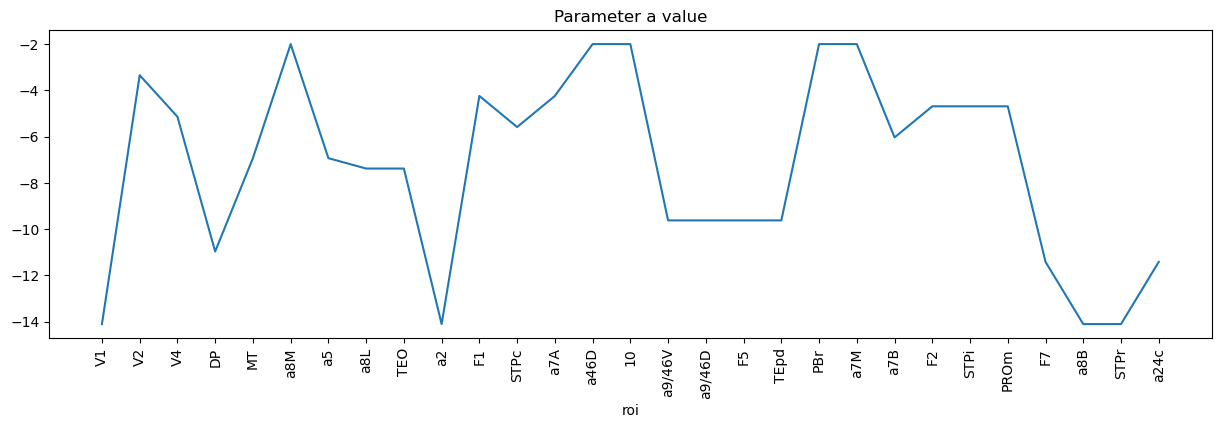

In [24]:
plt.figure(figsize=(15, 4))
a_model.plot()
plt.title("Parameter a value", fontsize=12)
plt.xticks(rotation=90);

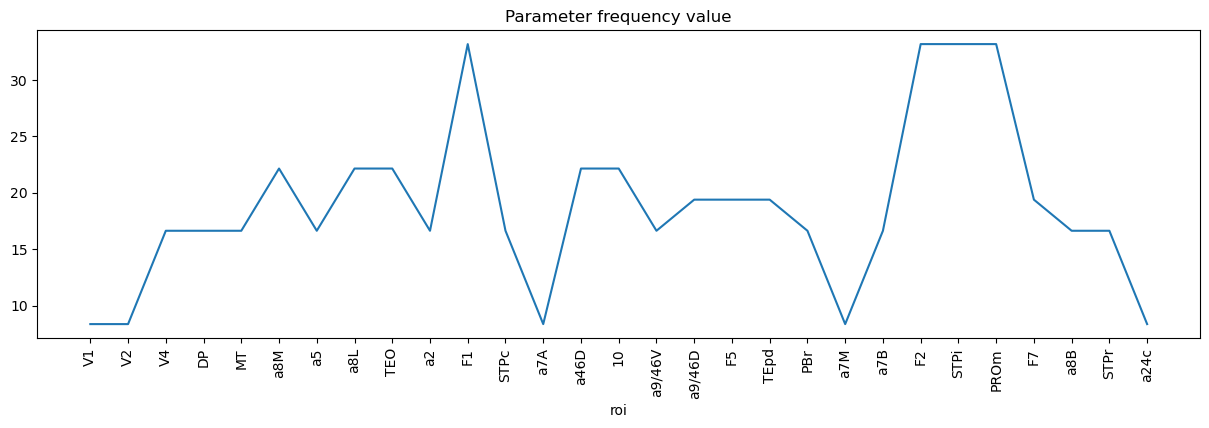

In [25]:
plt.figure(figsize=(15, 4))
f_model.plot()
plt.title("Parameter frequency value", fontsize=12)
plt.xticks(rotation=90);

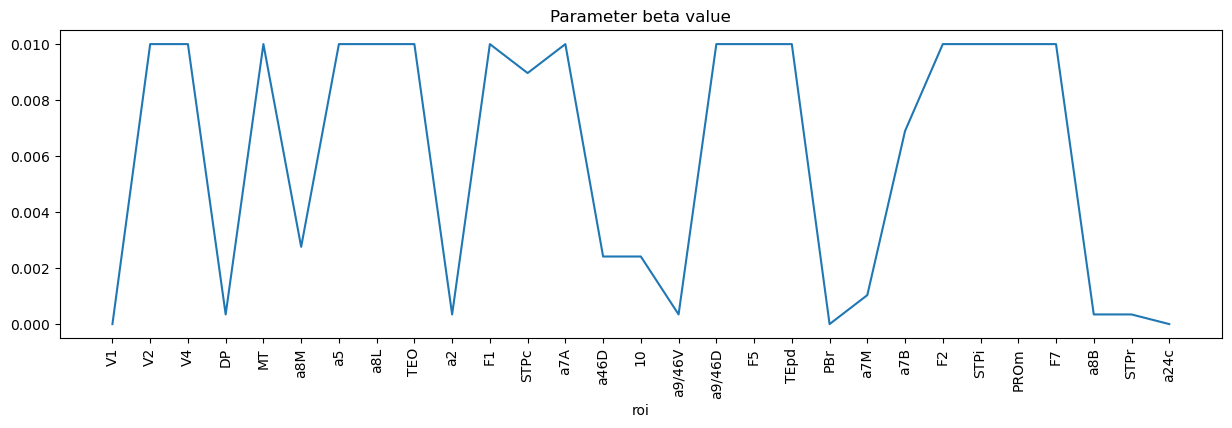

In [26]:
plt.figure(figsize=(15, 4))
beta_model.plot()
plt.title("Parameter beta value", fontsize=12)
plt.xticks(rotation=90);

In [27]:
from spectralMI import conn_spec_average

In [28]:
X = data.sel(roi=["V1", "V4"]).real

In [33]:
coh = conn_spec_average(X, fmin=0.1, fmax=80, roi="roi", sfreq=1000, bandwidth=3)

WARNING | No time vector. A default one is created
Defining links (n_roi=2; directed=False; net=False, nb_min_links=None)
    Sorting roi names
Computing pairwise coh (n_pairs=1, decim=1


    Using multitaper spectrum estimation with 11 DPSS windows


100%|████████████████████████████████████████|  : 1/1 [00:00<00:00, 3368.92it/s]


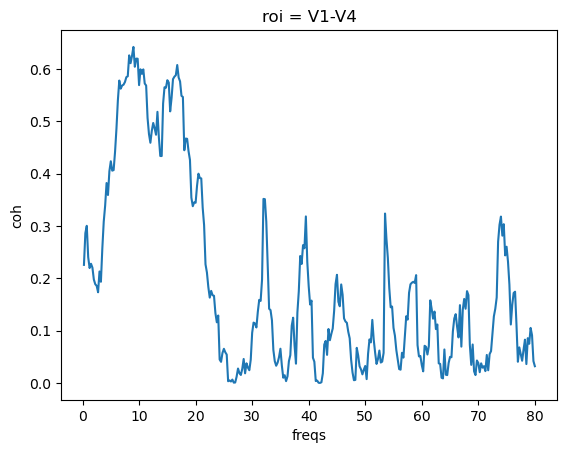

In [34]:
coh[0].plot()

#### Decompose in time-frequency domain


In [ ]:
freqs = np.linspace(0.3, 80, 60)

S = tfr_array_morlet(
    data.values.real,
    fsamp / decim,
    freqs,
    freqs / 2,
    output="complex",
    n_jobs=1,
    zero_mean=False,
    verbose=True,
)

S = xr.DataArray(
    S,
    dims=("trials", "roi", "freqs", "times"),
    coords={"freqs": freqs, "times": data.times.values, "roi": area_names},
)

In [ ]:
### Compute phase and amplitude terms


def _mi(S, roi_x, roi_y, stim):

    # Define the function to compute MI using HOI and JAX
    mi_fcn = get_mi("gc")

    # vectorize the function to first and second dimension
    gcmi = jax.vmap(jax.vmap(mi_fcn, in_axes=0), in_axes=0)

    times, freqs = S.times.values, S.freqs.values
    x = S.sel(roi=[roi_x]).data.squeeze()
    y = S.sel(roi=[roi_y]).data.squeeze()

    edge = x * np.conj(y)
    edge_r, edge_i = np.real(edge), np.imag(edge)

    E1 = np.stack((edge_r, edge_i), axis=1)
    E1 = np.moveaxis(E1, [0, 1], [-1, -2])

    # Stims across trials
    stim = data.trials.values
    stim = np.expand_dims(stim, axis=(0, 1))
    stim = np.tile(stim, (len(freqs), data.sizes["times"], 1, 1))

    E1 = copnorm_nd(E1, axis=-1)
    stim = copnorm_nd(stim, axis=-1)

    mi = gcmi(E1, stim).T

    return xr.DataArray(mi, dims=("times", "freqs"), coords=(times, freqs))


pairs = np.stack([[[0] * 28], [range(1, 29)]], axis=1).squeeze().T

rois = S.roi.values
stim = np.arange(100)  # data.trials.values

out = []
for i, j in tqdm(pairs):
    out += [_mi(S, rois[i], rois[j], stim)]


plt.figure(figsize=(40, 40))

for pos, _out in enumerate(out):
    plt.subplot(6, 5, pos + 1)
    i, j = pairs[pos]
    _out.T.plot(
        cmap="turbo",
    )
    plt.title(f"{rois[i]}-{rois[j]}")
    plt.xticks(fontsize=9)
    plt.yticks(fontsize=9)
    plt.ylabel("freq [Hz]", fontsize=9)
    plt.xlabel("time [s]", fontsize=9)

In [58]:
plt.figure(figsize=(40, 40))

targets = data.roi.values[1:]

for pos, target in enumerate(targets):

    x = data.sel(roi="V1") * np.conj(data.sel(roi=target))

    R1 = (x * np.conj(x)).data.real
    R2 = np.unwrap(np.angle(x))

    # Stims across trials
    stim = np.expand_dims(Amplitudes, axis=(0, 1))
    stim = np.tile(stim, (data.sizes["times"], 1)).squeeze().T

    from frites.core import copnorm_nd, gccmi_nd_ccc, gcmi_1d_cc, gcmi_nd_cc

    ax = plt.subplot(6, 5, pos + 1)
    I_S_12 = gccmi_nd_ccc(R1, R2, stim, traxis=0)
    I_S_1 = gcmi_nd_cc(stim, R1, traxis=0)
    I_S_2 = gcmi_nd_cc(stim, R2, traxis=0)
    R_12 = np.minimum(I_S_1, I_S_2)

    # plt.plot(S.times.values, I_S_12)
    plt.plot(x.times.values, I_S_1 - R_12)
    plt.plot(x.times.values, I_S_2 - R_12)
    plt.legend(
        ["Unique Amplitude", "Unique Phase"],
        fontsize=12,
        frameon=False,
    )
    [ax.spines[key].set_visible(False) for key in ["top", "right"]]
    plt.ylabel("[bits]", fontsize=12)
    plt.xlabel("time [s]", fontsize=12)
    plt.title(f"V1-{target}")

NameError: name 'Amplitudes' is not defined

<Figure size 4000x4000 with 0 Axes>

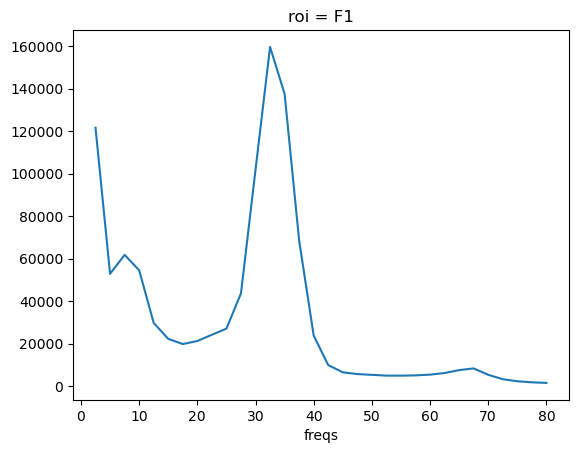

In [72]:
xr.concat(sxx, "sessions").mean("sessions").groupby("roi").mean("roi")[0].sel(
    roi="F1"
).plot()

<function __main__.xr_psd_array_multitaper(data, bandwidth=1.0, n_jobs=1, fmin=0.1, fmax=80)>

In [27]:
simulate

<function src.models.simulate(A: numpy.ndarray, g: float, f: float, a: float, fs: float, eta: float, T: float, Iext: numpy.ndarray = None, seed: int = 0, device: str = 'cpu', decim: int = 1, stim_mode: str = 'amp')>

100%|████████████████████████████████████████████████████████| 100/100 [00:49<00:00,  2.02it/s]


    Using multitaper spectrum estimation with 1 DPSS windows


In [128]:
sxx_data = sxx_data / sxx_data.max("freqs")
sxx_sim = sxx_sim / sxx_sim.max("freqs")

In [129]:
mse = [mean_squared_error(sxx_data, sxx_sim_) for sxx_sim_ in sxx_sim]

In [130]:
mse = np.reshape(mse, (60, 60))

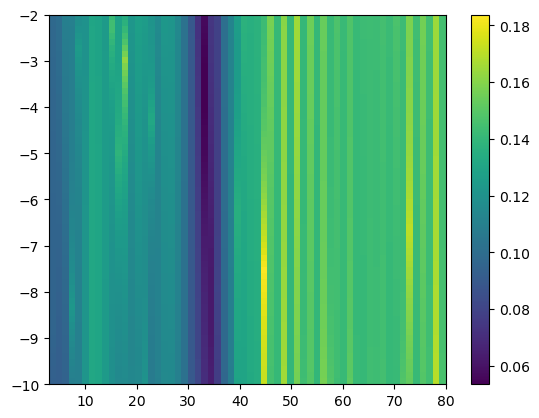

In [131]:
plt.imshow(mse, aspect="auto", origin="lower", extent=[3, 80, -10, -2])
plt.colorbar()

In [132]:
params[np.argmin(mse), :]

array([-3.62711864, 33.01694915])

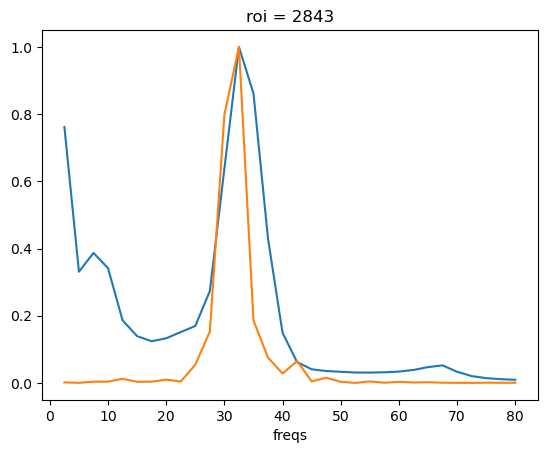

In [133]:
sxx_data.plot()
sxx_sim[np.argmin(mse)].plot()